# Masterthesis
## Regression

#### Julian Jetz

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import category_encoders as ce
import sklearn as sk
import seaborn as sns
from tensorflow.python.data import Dataset
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasRegressor 
from sklearn.model_selection import RandomizedSearchCV, KFold 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler, LabelBinarizer, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.ensemble import RandomForestRegressor 
import matplotlib.pyplot as plt
from scipy import stats

Using TensorFlow backend.


In [2]:
na_values = ['nan', 'N/A', 'NaN', 'NaT']

In [3]:
df = pd.read_csv('resources/accident_data.csv', sep=";", na_values=na_values, index_col=False, dtype = {"STATE" : "str", "TYPE" : "str", "TYPEQ" : "str", "WEATHER" : "str", "VISIBLTY" : "str", "SPD_TOO_HIGH" : "str"})

In [4]:
df=df.dropna(subset=['WEATHER', 'VISIBLTY'])
pd.set_option('display.max_columns', 500)
#df.head(50)

## Vorbereitungen

Festlegen der abhängigen Variablen X und der vorherzusagenden Variable y

In [5]:
x_data = df[['TEMP', 'TYPEQ', 'TRKCLAS', 'ACCCAUSE_LVL1', 'ACCCAUSE_LVL2', 'ACCAUSE', 'YEAR4', 'STATE', 'MONTH', 'LOCOMOTIVES1', 'LOADF1', 'LOADP1', 'EMPTYF1', 'EMPTYP1','LOCOMOTIVES2', 'LOADF2', 'EMPTYF2', 'LOADP2', 'EMPTYP2', 'TONS', 'TEMP_CLUSTER', 'SPEED', 'ACCCAUSE_LVL1', 'TYPE', 'EQUIPMENT_TYPE', 'TYPTRK', 'VISIBLTY', 'WEATHER', 'SPD_TOO_HIGH', 'ACCTYPE', 'ACCIDENT_TYPE', 'Jahreszeit']]

In [6]:
y = df['INFRASTRUCTURE_DMG']

In [7]:
print(x_data.isnull().sum())

TEMP              0
TYPEQ             0
TRKCLAS           0
ACCCAUSE_LVL1     0
ACCCAUSE_LVL2     0
ACCAUSE           0
YEAR4             0
STATE             0
MONTH             0
LOCOMOTIVES1      0
LOADF1            0
LOADP1            0
EMPTYF1           0
EMPTYP1           0
LOCOMOTIVES2      0
LOADF2            0
EMPTYF2           0
LOADP2            0
EMPTYP2           0
TONS              0
TEMP_CLUSTER      0
SPEED             0
ACCCAUSE_LVL1     0
TYPE              0
EQUIPMENT_TYPE    0
TYPTRK            0
VISIBLTY          0
WEATHER           0
SPD_TOO_HIGH      0
ACCTYPE           0
ACCIDENT_TYPE     0
Jahreszeit        0
dtype: int64


## Umwandlung der kategorialen Merkmale und Normalisierung der kontinuierlichen Merkmale

In [8]:
# Funktion zur Umwandlung der kategorialen Merkmale mit dem One Hot Encoder 
# x = kategoriale Merkmale
def prepare_inputs_One_Hot(x):
    encoder = OneHotEncoder(sparse=False)
    encoder.fit(x)
    x_enc = encoder.transform(x)
    return x_enc

In [9]:
# Funktion zur Umwandlung der kategorialen Merkmale mit dem Ordinal Encoder 
# x = kategoriale Merkmale
def prepare_inputs_Ordinal(x):
    encoder = OrdinalEncoder()
    encoder.fit(x)
    x_enc = encoder.transform(x)
    return x_enc

In [10]:
# Funktion zur Umwandlung der kategorialen Merkmale mit dem Binary Encoder
# x = Datensatz, cats = Liste mit Spaltenüberschriften der kategorialen Merkmale
def prepare_inputs_Binary(x, cats):
    encoder = ce.BinaryEncoder(cols=cats, return_df=True)
    encoder.fit(x[cats])
    df_bin = encoder.transform(x[cats])
    return df_bin

In [11]:
# Funktion zur Umwandlung der kategorialen Merkmale mit dem Target Encoder
# x = Datensatz, cats = Liste mit Spaltenüberschriften der kategorialen Merkmale, Y = unabhägiges Merkmal
def prepare_inputs_Target(x, Y, cats, smoothing=1):
    encoder = ce.TargetEncoder(cols=cats, return_df=True, min_samples_leaf = 5, smoothing=smoothing)
    encoder.fit(x[cats], Y)
    df_te = encoder.transform(x[cats], Y)
    return df_te

In [12]:
# Funktion zur Umwandlung der kategorialen Merkmale mit dem Leave One Out Encoder
# x = Datensatz, cats = Liste mit Spaltenüberschriften der kategorialen Merkmale, Y = unabhägiges Merkmal
def prepare_inputs_Leave_One_Out(x, Y, cats):
    encoder = ce.LeaveOneOutEncoder(cols=cats, return_df=True)
    encoder.fit(x[cats], Y)
    df_loo = encoder.transform(x[cats], Y)
    return df_loo

### Merkmale, die betrachtet werden





In [13]:
#cat = ['TEMP_CLUSTER', 'Jahreszeit', 'EQUIPMENT_TYPE', 'ACCIDENT_TYPE', 'TYPTRK', 'WEATHER', 'VISIBLTY', 'STATE', 'ACCCAUSE_LVL1', 'SPD_TOO_HIGH', 'ACCTYPE', 'TRKCLAS']

In [14]:
#con = ['SPEED', 'TONS', 'YEAR4', 'LOADF1', 'EMPTYF1', 'LOADP1', 'EMPTYP1', 'LOCOMOTIVES1', 'LOADF2', 'EMPTYF2', 'LOADP2', 'EMPTYP2', 'LOCOMOTIVES2']

In [15]:
cat = ['TEMP_CLUSTER', 'Jahreszeit', 'EQUIPMENT_TYPE', 'ACCIDENT_TYPE', 'ACCTYPE', 'TRKCLAS']

In [16]:
con = ['SPEED', 'TONS', 'YEAR4', 'LOADF1', 'EMPTYF1', 'LOADP1', 'EMPTYP1', 'LOCOMOTIVES1' , 'LOADF2', 'EMPTYF2', 'LOADP2', 'EMPTYP2', 'LOCOMOTIVES2']

In [17]:
#x_enc_cat = prepare_inputs_Ordinal(x_data[cat])

In [18]:
x_enc_cat = prepare_inputs_One_Hot(x_data[cat])

In [19]:
#x_enc_cat = prepare_inputs_Binary(x_data, cat)

In [20]:
#x_enc_cat = prepare_inputs_Target(x_data, y, cat)

In [21]:
#x_enc_cat = prepare_inputs_Leave_One_Out(x_data, y, cat)

In [22]:
# Normalisierung der kontinuierlichen Merkmale mit dem StandardScaler oder dem MinMaxScaler
#cs = MinMaxScaler().fit(x_data[con])
cs = StandardScaler().fit(x_data[con])
x_enc_con = cs.transform(x_data[con])
#x_enc_con = x_data[con]

In [23]:
#cs_y = MinMaxScaler().fit(y.values.reshape(-1, 1))
#cs_y = StandardScaler().fit(y.values.reshape(-1, 1))
#y = cs_y.transform(y.values.reshape(-1, 1))

#### Zusammenfügen der kategorialen und kontinuierlichen Merkmale

In [24]:
X_Data = np.hstack([x_enc_cat, x_enc_con])

#### Aufteilen der Merkmale in Trainings- und Testdaten
70% Trainingsdaten & 30 % Testdaten
random_state: Kontrolliert die Zufallsverteilung -> Es werden immer die gleichen Werte Trainings- und Testdaten zugeteilt. Sonst könnte es zu Abweichungen bei den Ergebnissen des Modells kommen

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_Data, y, test_size=0.3, random_state=42)

In [26]:
n_features = X_train.shape[1]

## Sequential regression model

In [27]:
def create_model(learning_rate = 0.001, activation = 'relu', activation2='relu', dropout=0, opt = None):
    seq_model = Sequential()
    
    if (opt == None):
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
     
    seq_model.add(Dense(512, activation=activation, input_shape=(n_features,)))
    #seq_model.add(BatchNormalization())
    seq_model.add(Dropout(dropout))
    seq_model.add(Dense(256, activation=activation2))
    #seq_model.add(Dense(128, activation=activation))
    #seq_model.add(Dropout(dropout))
    #seq_model.add(Dense(64, activation=activation))
    #seq_model.add(Dropout(dropout))
    #seq_model.add(Dense(32, activation=activation))
    #seq_model.add(Dropout(dropout))
    seq_model.add(Dense(1))
    seq_model.compile(optimizer=opt, loss='mse', metrics=['mse', tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mae'])
    return seq_model

In [28]:
model = KerasRegressor(build_fn = create_model)

In [29]:
params = {'activation': ["relu", "selu"], 'activation2': ["relu", "selu"], 'batch_size' : [32, 256, 512], 'epochs': [5, 50, 100, 300, 500],'learning_rate': [0.01, 0.001, 0.0005, 0.0001]}

In [30]:
scoring = {'MSE': 'neg_mean_squared_error', 'r2' : 'r2', 'mae': 'neg_mean_absolute_error'}

In [31]:
random_search = RandomizedSearchCV(model, param_distributions = params,cv = KFold(20), return_train_score=True, scoring=scoring, refit='MSE')

In [32]:
#random_search_results = random_search.fit(X_train, y_train)

In [33]:
#print("Best Score: ",random_search_results.best_score_,"and Best Params: ",random_search_results.best_params_)

In [34]:
def displaySearchCVResults(result, resultCount=10):


    mse_score = result.best_score_
    mae_score = result.cv_results_['mean_test_mae'][result.best_index_]
    r2_score = result.cv_results_['mean_test_r2'][result.best_index_]
    stdev_mse = result.cv_results_['std_test_MSE'][result.best_index_]
    stdev_mae = result.cv_results_['std_test_mae'][result.best_index_]
    stdev_r2 = result.cv_results_['std_test_r2'][result.best_index_]
    cv_results = result.cv_results_

    params = result.best_params_
    
    print("Beste Parameter: {}".format(params))
    print("Bester MSE Wert:      {:0.5f} (+/-{:0.5f})".format(mse_score, stdev_mse))
    print("Bester MAE Wert:      {:0.5f} (+/-{:0.5f})".format(mae_score, stdev_mae))
    print("Bester R2 Wert:      {:0.5f} (+/-{:0.5f})".format(r2_score, stdev_r2))
    import pprint
    estimator = result.best_estimator_
    pprint.pprint(estimator.get_params())

    display(pd.DataFrame(cv_results) \
            .sort_values(by='rank_test_MSE').head(resultCount))

In [35]:
#displaySearchCVResults(random_search, resultCount=15)

### Regression Allgemein

In [36]:
epochs = 150

In [37]:
epochs

150

In [38]:
learning_rate = 0.01

In [39]:
learning_rate

0.01

In [40]:
dropout = 0

In [41]:
dropout

0

In [42]:
es = EarlyStopping(monitor='val_loss', patience=8)
red_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

In [43]:
metrics = ['mse', tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mae']

In [44]:
activation = 'relu'
activation2='relu'

In [45]:
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
#opt = tf.keras.optimizers.Adadelta()
#opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)

## Sequential Regression with Keras

In [46]:
seq_model = create_model(learning_rate = learning_rate, activation = activation, activation2=activation2, dropout=dropout, opt=opt)

In [47]:
"""
seq_model = Sequential()

#seq_model.add(Dense(int(n_features*2/3), activation=activation, input_shape=(n_features,)))
seq_model.add(Dense(512, activation='selu', input_shape=(n_features,)))
#seq_model.add(BatchNormalization())
seq_model.add(Dropout(dropout))
seq_model.add(Dense(256, activation='relu'))
#seq_model.add(BatchNormalization())
#seq_model.add(Dense(int(n_features*2/3), activation=activation))
#seq_model.add(Dropout(dropout))
#seq_model.add(Dense(64, activation=activation))
#seq_model.add(Dropout(dropout))
#seq_model.add(Dense(32, activation=activation))
#seq_model.add(Dropout(dropout))
seq_model.add(Dense(1))
seq_model.compile(optimizer=opt, loss='mse', metrics=metrics)
"""

"\nseq_model = Sequential()\n\n#seq_model.add(Dense(int(n_features*2/3), activation=activation, input_shape=(n_features,)))\nseq_model.add(Dense(512, activation='selu', input_shape=(n_features,)))\n#seq_model.add(BatchNormalization())\nseq_model.add(Dropout(dropout))\nseq_model.add(Dense(256, activation='relu'))\n#seq_model.add(BatchNormalization())\n#seq_model.add(Dense(int(n_features*2/3), activation=activation))\n#seq_model.add(Dropout(dropout))\n#seq_model.add(Dense(64, activation=activation))\n#seq_model.add(Dropout(dropout))\n#seq_model.add(Dense(32, activation=activation))\n#seq_model.add(Dropout(dropout))\nseq_model.add(Dense(1))\nseq_model.compile(optimizer=opt, loss='mse', metrics=metrics)\n"

In [48]:
seq_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               24576     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 156,161
Trainable params: 156,161
Non-trainable params: 0
_________________________________________________________________


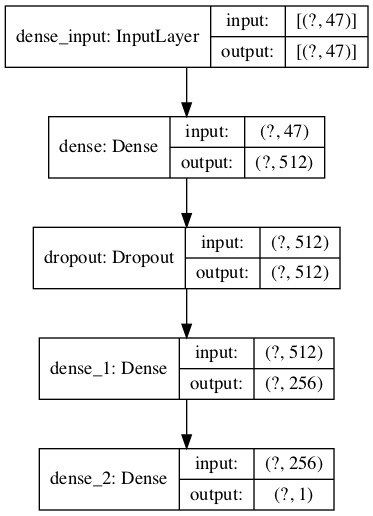

In [49]:
plot_model(seq_model, 'Images/Sequential Regression Model.png', show_shapes=True)

In [50]:
#history = seq_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, callbacks=[es])
#history = seq_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, callbacks=[red_lr])
#history = seq_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, callbacks=[es, red_lr])
history = seq_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs)

Epoch 1/150
1385/1385 [==============================] - 3s 2ms/step - loss: 8054486528.0000 - mse: 8054486528.0000 - rmse: 89746.7891 - mae: 41542.4922 - val_loss: 6619383808.0000 - val_mse: 6619383808.0000 - val_rmse: 81359.5938 - val_mae: 37231.2266
Epoch 2/150
1385/1385 [==============================] - 3s 2ms/step - loss: 6693596160.0000 - mse: 6693596160.0000 - rmse: 81814.3984 - mae: 38082.6641 - val_loss: 6308271104.0000 - val_mse: 6308271104.0000 - val_rmse: 79424.6250 - val_mae: 37446.8672
Epoch 3/150
1385/1385 [==============================] - 3s 2ms/step - loss: 6582933504.0000 - mse: 6582933504.0000 - rmse: 81135.2812 - mae: 37760.0430 - val_loss: 6269397504.0000 - val_mse: 6269397504.0000 - val_rmse: 79179.5234 - val_mae: 37451.7148
Epoch 4/150
1385/1385 [==============================] - 3s 2ms/step - loss: 6459192320.0000 - mse: 6459192320.0000 - rmse: 80369.1016 - mae: 37452.4375 - val_loss: 6449263104.0000 - val_mse: 6449263104.0000 - val_rmse: 80307.3047 - val_mae:

1385/1385 [==============================] - 3s 2ms/step - loss: 5140969472.0000 - mse: 5140969472.0000 - rmse: 71700.5547 - mae: 34576.4883 - val_loss: 6142906880.0000 - val_mse: 6142906880.0000 - val_rmse: 78376.6953 - val_mae: 36593.5000
Epoch 34/150
1385/1385 [==============================] - 3s 2ms/step - loss: 5055643648.0000 - mse: 5055643648.0000 - rmse: 71103.0469 - mae: 34308.9727 - val_loss: 6179369472.0000 - val_mse: 6179369472.0000 - val_rmse: 78608.9688 - val_mae: 36437.1367
Epoch 35/150
1385/1385 [==============================] - 4s 3ms/step - loss: 5002415104.0000 - mse: 5002415104.0000 - rmse: 70727.7500 - mae: 34166.7578 - val_loss: 6488486912.0000 - val_mse: 6488486912.0000 - val_rmse: 80551.1484 - val_mae: 38654.7109
Epoch 36/150
1385/1385 [==============================] - 3s 2ms/step - loss: 4899682816.0000 - mse: 4899682816.0000 - rmse: 69997.7344 - mae: 34011.4180 - val_loss: 6438055936.0000 - val_mse: 6438055936.0000 - val_rmse: 80237.5000 - val_mae: 37555.01

1385/1385 [==============================] - 3s 2ms/step - loss: 2886577664.0000 - mse: 2886577664.0000 - rmse: 53726.8789 - mae: 29390.8379 - val_loss: 7238032896.0000 - val_mse: 7238032896.0000 - val_rmse: 85076.6328 - val_mae: 37318.4805
Epoch 66/150
1385/1385 [==============================] - 3s 2ms/step - loss: 2895572224.0000 - mse: 2895572224.0000 - rmse: 53810.5234 - mae: 29404.7188 - val_loss: 7090987520.0000 - val_mse: 7090987520.0000 - val_rmse: 84208.0000 - val_mae: 37560.2852
Epoch 67/150
1385/1385 [==============================] - 3s 2ms/step - loss: 2823031808.0000 - mse: 2823031808.0000 - rmse: 53132.2109 - mae: 29143.3418 - val_loss: 7587817472.0000 - val_mse: 7587817472.0000 - val_rmse: 87108.0781 - val_mae: 38059.1602
Epoch 68/150
1385/1385 [==============================] - 3s 2ms/step - loss: 2780725504.0000 - mse: 2780725504.0000 - rmse: 52732.5859 - mae: 29175.5410 - val_loss: 7315142144.0000 - val_mse: 7315142144.0000 - val_rmse: 85528.6016 - val_mae: 37206.98

1385/1385 [==============================] - 3s 2ms/step - loss: 2009905536.0000 - mse: 2009905536.0000 - rmse: 44831.9688 - mae: 26479.1738 - val_loss: 8213103616.0000 - val_mse: 8213103616.0000 - val_rmse: 90626.1719 - val_mae: 38678.2344
Epoch 98/150
1385/1385 [==============================] - 3s 2ms/step - loss: 1979948928.0000 - mse: 1979948928.0000 - rmse: 44496.6172 - mae: 26387.5723 - val_loss: 7961549824.0000 - val_mse: 7961549824.0000 - val_rmse: 89227.5156 - val_mae: 38104.0430
Epoch 99/150
1385/1385 [==============================] - 3s 2ms/step - loss: 1933756800.0000 - mse: 1933756800.0000 - rmse: 43974.5000 - mae: 26228.5918 - val_loss: 8213564928.0000 - val_mse: 8213564928.0000 - val_rmse: 90628.7188 - val_mae: 37890.2500
Epoch 100/150
1385/1385 [==============================] - 3s 2ms/step - loss: 1960842624.0000 - mse: 1960842624.0000 - rmse: 44281.4023 - mae: 26208.9707 - val_loss: 8408559616.0000 - val_mse: 8408559616.0000 - val_rmse: 91698.1953 - val_mae: 39441.4

1385/1385 [==============================] - 2s 2ms/step - loss: 1609106816.0000 - mse: 1609106816.0000 - rmse: 40113.6719 - mae: 24604.5586 - val_loss: 8349686272.0000 - val_mse: 8349686272.0000 - val_rmse: 91376.6172 - val_mae: 38860.1211
Epoch 130/150
1385/1385 [==============================] - 2s 2ms/step - loss: 1562591872.0000 - mse: 1562591872.0000 - rmse: 39529.6328 - mae: 24554.2324 - val_loss: 8090421760.0000 - val_mse: 8090421760.0000 - val_rmse: 89946.7734 - val_mae: 38681.3125
Epoch 131/150
1385/1385 [==============================] - 2s 2ms/step - loss: 1549564800.0000 - mse: 1549564800.0000 - rmse: 39364.5117 - mae: 24366.5938 - val_loss: 8520946688.0000 - val_mse: 8520946688.0000 - val_rmse: 92308.9766 - val_mae: 39353.1680
Epoch 132/150
1385/1385 [==============================] - 2s 2ms/step - loss: 1596715008.0000 - mse: 1596715008.0000 - rmse: 39958.9180 - mae: 24563.2129 - val_loss: 8399748608.0000 - val_mse: 8399748608.0000 - val_rmse: 91650.1406 - val_mae: 39282

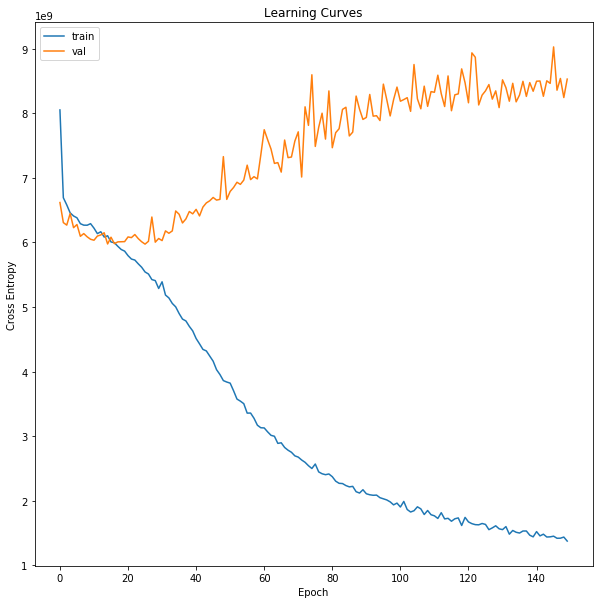

In [51]:
plt.figure(figsize=(10,10))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.legend()
plt.show()

In [52]:
# Evaluation des Regressionsmodells
error = seq_model.evaluate(X_test, y_test)

594/594 [==============================] - 0s 693us/step - loss: 8532214784.0000 - mse: 8532214784.0000 - rmse: 92369.9922 - mae: 38794.0781


In [53]:
print('MSE: %.3f, RMSE: %.3f, MAE: %.3f' % 
      (error[1], error[2], error[3]))

MSE: 8532214784.000, RMSE: 92369.992, MAE: 38794.078


Text(0, 0.5, 'Vorhergesagte Werte (Test Daten)')

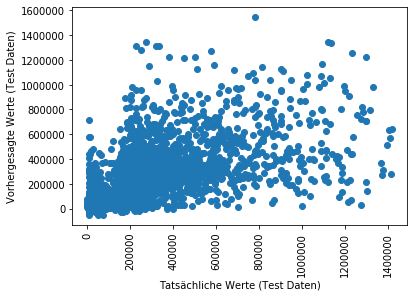

In [54]:
# Scatter Plot mit den tatsächlichen und den vorhergesagten Daten für die Test Data

predictions= seq_model.predict(X_test)
plt.plot(y_test, predictions, 'o')
plt.xlabel('Tatsächliche Werte (Test Daten)')
plt.xticks(rotation=90)
plt.ylabel('Vorhergesagte Werte (Test Daten)')

In [55]:
# Berechnung des R2-Scores (Bestimmtheitsmaß)
r2_seq = r2_score(y_test, predictions)
r2_seq

0.5463485111445552

In [56]:
# Berechnung des adjustierten R2-Scores (adj. Bestimmtheitsmaß)
adj_r2_seq = 1-(1-r2_seq)*((len(X_test)-1)/(len(X_test)-(len(cat)+len(con))))

In [57]:
print(('%.6f \t %.6f \t %.0f  \t %.0f \t %.0f' % 
      (r2_seq, adj_r2_seq, error[2], error[1], error[3])).replace('.', ','))

0,546349 	 0,545918 	 92370  	 8532214784 	 38794


Text(0, 0.5, 'Vorhergesagte Werte (Trainings Daten)')

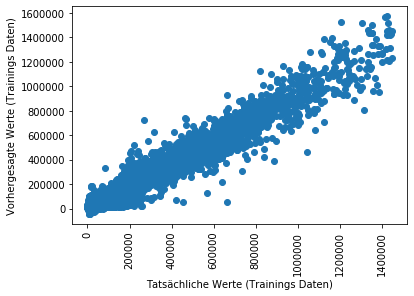

In [58]:
# Scatter Plot mit den tatsächlichen und den vorhergesagten Daten für die Training Data
train_predictions=seq_model.predict(X_train)
plt.plot(y_train, train_predictions, 'o')
plt.xlabel('Tatsächliche Werte (Trainings Daten)')
plt.xticks(rotation=90)
plt.ylabel('Vorhergesagte Werte (Trainings Daten)')

In [59]:
predictions = predictions.flatten()

In [60]:
train_predictions = train_predictions.flatten()

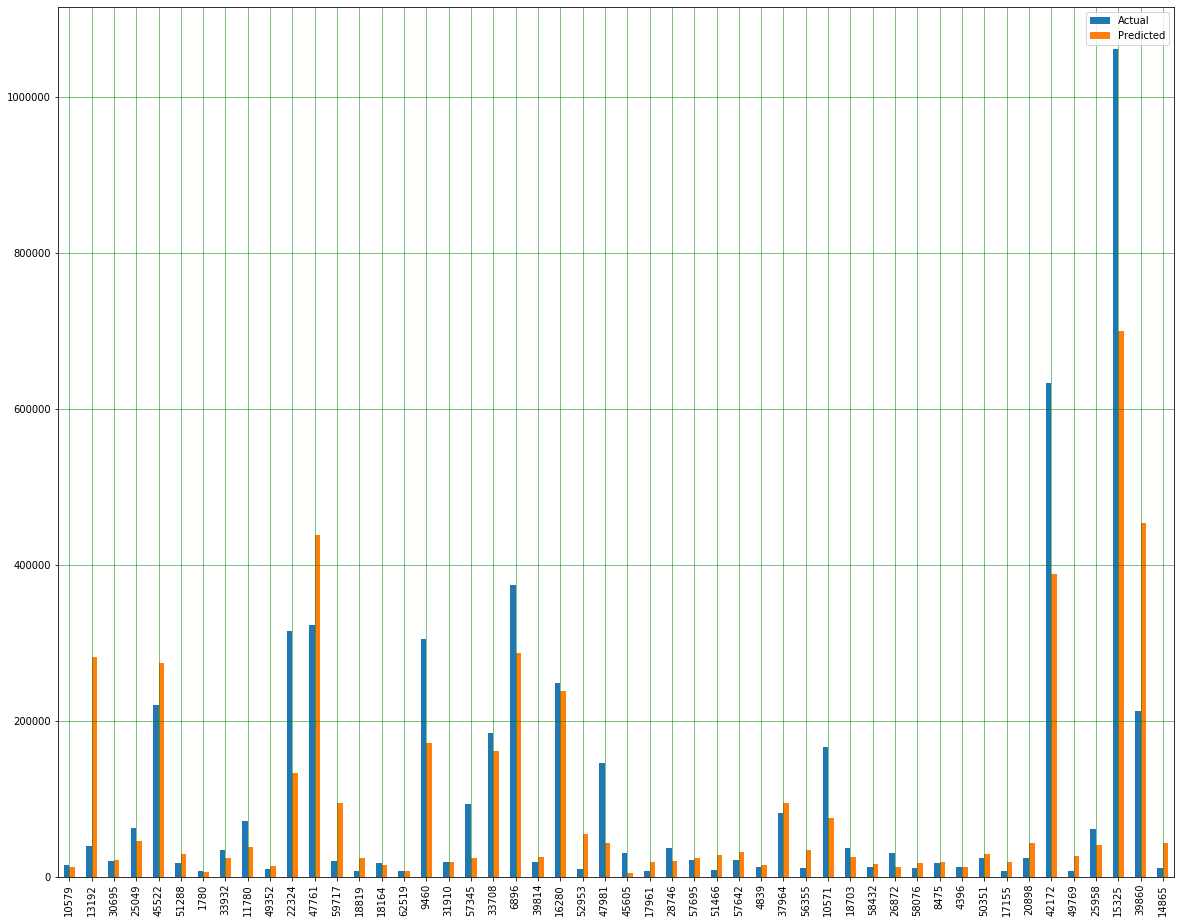

In [61]:
pred = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
pred1 = pred.sample(50)

pred1.plot(kind='bar',figsize=(20,16))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

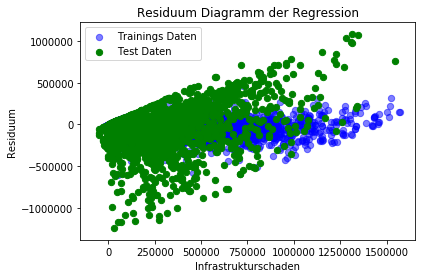

In [62]:
# Differenzen zwischen vorhergesagten und tatsächlichen Werten
plt.scatter(train_predictions, train_predictions - y_train, c='b', s=40, alpha=0.5, label='Trainings Daten')
plt.scatter(predictions, predictions - y_test, c='g', s=40, label='Test Daten')
plt.hlines(y=0, xmin=-0.03, xmax=0.2)
plt.title('Residuum Diagramm der Regression')
plt.ylabel('Residuum')
plt.xlabel('Infrastrukturschaden')
plt.legend()
plt.show()

## Functional API Regression Model with Keras

In [63]:
x_in = Input(shape=(n_features,))
dense = Dense(1024, activation=activation)
x = dense(x_in)
x = Dropout(dropout)(x)
x = Dense(512, activation=activation2)(x)
#x = Dense(256, activation=activation)(x)
#x = Dropout(dropout)(x)
#x = Dense(128, activation=activation)(x)
#x = Dropout(dropout)(x)
#x = Dense(64, activation=activation)(x)
#x = Dropout(dropout)(x)
x_out = Dense(1)(x)
func_model = Model(inputs=x_in, outputs=x_out)

In [64]:
func_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 47)]              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              49152     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513       
Total params: 574,465
Trainable params: 574,465
Non-trainable params: 0
_________________________________________________________________


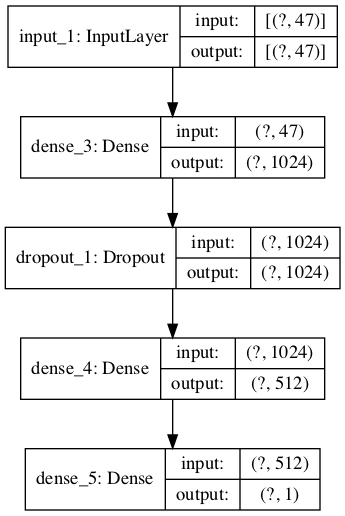

In [65]:
plot_model(func_model, 'Images/Functional API Regression Model.png', show_shapes=True)

In [66]:
func_model.compile(optimizer=opt, loss='mse', metrics=metrics)

In [ ]:
#func_history = func_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, callbacks=[es])
#func_history = func_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, callbacks=[red_lr])
#func_history = func_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, callbacks=[es, red_lr])
func_history = func_model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                        epochs=epochs, batch_size=32)

Epoch 1/150
1385/1385 [==============================] - 6s 4ms/step - loss: 7231261696.0000 - mse: 7231261696.0000 - rmse: 85036.8281 - mae: 39595.6250 - val_loss: 6281569280.0000 - val_mse: 6281569280.0000 - val_rmse: 79256.3516 - val_mae: 37198.7344
Epoch 2/150
1385/1385 [==============================] - 5s 4ms/step - loss: 6595932672.0000 - mse: 6595932672.0000 - rmse: 81215.3438 - mae: 37697.5000 - val_loss: 6663597056.0000 - val_mse: 6663597056.0000 - val_rmse: 81630.8594 - val_mae: 42070.0273
Epoch 3/150
1385/1385 [==============================] - 6s 4ms/step - loss: 6376506368.0000 - mse: 6376506368.0000 - rmse: 79853.0312 - mae: 37285.3281 - val_loss: 6016442880.0000 - val_mse: 6016442880.0000 - val_rmse: 77565.7344 - val_mae: 36666.6289
Epoch 4/150
1385/1385 [==============================] - 6s 4ms/step - loss: 6411863040.0000 - mse: 6411863040.0000 - rmse: 80074.1094 - mae: 36829.4062 - val_loss: 6019052544.0000 - val_mse: 6019052544.0000 - val_rmse: 77582.5547 - val_mae:

1385/1385 [==============================] - 5s 4ms/step - loss: 3932537856.0000 - mse: 3932537856.0000 - rmse: 62709.9492 - mae: 32037.6562 - val_loss: 6802949632.0000 - val_mse: 6802949632.0000 - val_rmse: 82479.9922 - val_mae: 35986.9062
Epoch 34/150
1385/1385 [==============================] - 6s 4ms/step - loss: 3866283264.0000 - mse: 3866283264.0000 - rmse: 62179.4453 - mae: 31707.8145 - val_loss: 6712197632.0000 - val_mse: 6712197632.0000 - val_rmse: 81928.0000 - val_mae: 36803.7852
Epoch 35/150
1385/1385 [==============================] - 5s 4ms/step - loss: 3805338368.0000 - mse: 3805338368.0000 - rmse: 61687.4258 - mae: 31673.0449 - val_loss: 7035562496.0000 - val_mse: 7035562496.0000 - val_rmse: 83878.2578 - val_mae: 35264.6094
Epoch 36/150
1385/1385 [==============================] - 7s 5ms/step - loss: 3649536256.0000 - mse: 3649536256.0000 - rmse: 60411.3906 - mae: 31299.3164 - val_loss: 6868356608.0000 - val_mse: 6868356608.0000 - val_rmse: 82875.5469 - val_mae: 36209.16

1385/1385 [==============================] - 6s 5ms/step - loss: 2185753344.0000 - mse: 2185753344.0000 - rmse: 46752.0430 - mae: 27015.9180 - val_loss: 7796924928.0000 - val_mse: 7796924928.0000 - val_rmse: 88300.1953 - val_mae: 38061.6953
Epoch 66/150
1385/1385 [==============================] - 5s 4ms/step - loss: 2149527552.0000 - mse: 2149527552.0000 - rmse: 46362.9961 - mae: 26832.5703 - val_loss: 7600983040.0000 - val_mse: 7600983040.0000 - val_rmse: 87183.6172 - val_mae: 37412.5742
Epoch 67/150
1385/1385 [==============================] - 6s 4ms/step - loss: 2157194496.0000 - mse: 2157194496.0000 - rmse: 46445.6094 - mae: 26829.7617 - val_loss: 7696834048.0000 - val_mse: 7696834048.0000 - val_rmse: 87731.6016 - val_mae: 38659.6680
Epoch 68/150
1385/1385 [==============================] - 6s 4ms/step - loss: 2095424896.0000 - mse: 2095424896.0000 - rmse: 45775.8125 - mae: 26615.3301 - val_loss: 7388487168.0000 - val_mse: 7388487168.0000 - val_rmse: 85956.3125 - val_mae: 37297.15

1385/1385 [==============================] - 5s 4ms/step - loss: 1497965568.0000 - mse: 1497965568.0000 - rmse: 38703.5586 - mae: 23839.7871 - val_loss: 7810866176.0000 - val_mse: 7810866176.0000 - val_rmse: 88379.1016 - val_mae: 38728.0156
Epoch 98/150
1385/1385 [==============================] - 5s 4ms/step - loss: 1568432768.0000 - mse: 1568432768.0000 - rmse: 39603.4453 - mae: 24130.6387 - val_loss: 7956288000.0000 - val_mse: 7956288000.0000 - val_rmse: 89198.0234 - val_mae: 38336.0352
Epoch 99/150
1385/1385 [==============================] - 5s 4ms/step - loss: 1516151168.0000 - mse: 1516151168.0000 - rmse: 38937.7852 - mae: 23800.7109 - val_loss: 8022659072.0000 - val_mse: 8022659072.0000 - val_rmse: 89569.2969 - val_mae: 38396.3945
Epoch 100/150
1385/1385 [==============================] - 5s 4ms/step - loss: 1441700224.0000 - mse: 1441700224.0000 - rmse: 37969.7266 - mae: 23585.9316 - val_loss: 7719899136.0000 - val_mse: 7719899136.0000 - val_rmse: 87862.9531 - val_mae: 39108.2

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(func_history.history['loss'], label='train')
plt.plot(func_history.history['val_loss'], label='val')
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.legend()
plt.show()

In [ ]:
# Evaluation des Regressionsmodells
error_func = func_model.evaluate(X_test, y_test, verbose=0)
print('MSE: %.3f, RMSE: %.3f, MAE: %.3f' % 
      (error_func[1], error_func[2], error_func[3]))

In [ ]:
# Scatter Plot mit den tatsächlichen und den vorhergesagten Daten für die Test Data
func_predictions=func_model.predict(X_test)
plt.plot(y_test, func_predictions, 'o')
plt.xlabel('Tatsächliche Werte (Test Daten)')
plt.xticks(rotation=90)
plt.ylabel('Vorhergesagte Werte (Test Daten)')

In [ ]:
# Berechnung des R2-Scores (Bestimmtheitsmaß)
r2_func = r2_score(y_test, func_predictions)
r2_func

In [ ]:
# Berechnung des adjustierten R2-Scores (adj. Bestimmtheitsmaß)
adj_r2_func = 1-(1-r2_func)*((len(X_test)-1)/(len(X_test)-(len(cat)+len(con))))
adj_r2_func

In [ ]:
print(('%.6f \t %.6f \t %.0f  \t %.0f \t %.0f' % 
      (r2_func, adj_r2_func, error_func[2], error_func[1], error_func[3])).replace('.', ','))

In [ ]:
# Scatter Plot mit den tatsächlichen und den vorhergesagten Daten für die Training Data
func_train_predictions=func_model.predict(X_train)
plt.plot(y_train, func_train_predictions, 'o')
plt.xlabel('Tatsächliche Werte (Trainings Daten)')
plt.xticks(rotation=90)
plt.ylabel('Vorhergesagte Werte (Trainings Daten)')

In [ ]:
func_predictions = func_predictions.flatten()

In [ ]:
func_train_predictions = func_train_predictions.flatten()

In [ ]:
pred = pd.DataFrame({'Actual': y_test, 'Predicted': func_predictions})
pred1 = pred.sample(50)

pred1.plot(kind='bar',figsize=(20,16))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [ ]:
# Differenzen zwischen vorhergesagten und tatsächlichen Werten
plt.scatter(func_train_predictions, func_train_predictions - y_train, c='b', s=40, alpha=0.5, label='Trainings Daten')
plt.scatter(func_predictions, func_predictions - y_test, c='g', s=40, label='Test Daten')
plt.hlines(y=0, xmin=-0.03, xmax=0.2)
plt.title('Residuum Diagramm der Regression')
plt.ylabel('Residuum')
plt.xlabel('Infrastrukturschaden')
plt.legend()
plt.show()

##  Regression with Scikit-Learn

In [ ]:
def get_rmse_r2(mod, X_test, y_Test):
    y_pred = mod.predict(X_test)
    r2 = r2_score(y_Test, y_pred)
    adj_r2 = 1-(1-r2)*((len(X_test)-1)/(len(X_test)-(len(cat)+len(con))))
    return np.sqrt(mean_squared_error(y_Test, y_pred)), r2, adj_r2, mod.__class__.__name__

In [ ]:
d_rmse = dict()
d_r2 = dict()
d_adj_r2 = dict()

In [ ]:
rfr = RandomForestRegressor(random_state=0, n_estimators=100)
rfr.fit(X_train, y_train)
rmse, r2, adj_r2, rfr_name = get_rmse_r2(rfr, X_test, y_test)
d_rmse['Random Forest Regression'] = [rmse]
d_r2['Random Forest Regression'] = [r2]
d_adj_r2['Random Forest Regression'] = [adj_r2]
print ('(' + rfr_name + ') RMSE:', rmse, ' R2:' , r2, 'Adjusted R2:', adj_r2)

In [ ]:
lr = LinearRegression().fit(X_train, y_train)
rmse, r2, adj_r2, lr_name = get_rmse_r2(lr, X_test, y_test)
d_rmse['Linear Regression'] = [rmse]
d_r2['Linear Regression'] = [r2]
d_adj_r2['Linear Regression'] = [adj_r2]
print ('(' + lr_name + ') RMSE:', rmse, ' R2:' , r2, 'Adjusted R2:', adj_r2)

In [ ]:
ridge = Ridge(random_state=0).fit(X_train, y_train)
rmse, r2, adj_r2, ridge_name = get_rmse_r2(ridge, X_test, y_test)
d_rmse['Ridge Regression'] = [rmse]
d_r2['Ridge Regression'] = [r2]
d_adj_r2['Ridge Regression'] = [adj_r2]
print ('(' + ridge_name + ') RMSE:', rmse, ' R2:' , r2, 'Adjusted R2:', adj_r2)

In [ ]:
lasso = Lasso(random_state=0).fit(X_train, y_train)
rmse, r2, adj_r2, lasso_name = get_rmse_r2(lasso, X_test, y_test)
d_rmse['Lasso Regression'] = [rmse]
d_r2['Lasso Regression'] = [r2]
d_adj_r2['Lasso Regression'] = [adj_r2]
print ('(' + lasso_name + ') RMSE:', rmse, ' R2:' , r2, 'Adjusted R2:', adj_r2)

In [ ]:
en = ElasticNet(random_state=0).fit(X_train, y_train)
rmse, r2, adj_r2, en_name = get_rmse_r2(en, X_test, y_test)
d_rmse['Elastic Net Regression'] = [rmse]
d_r2['Elastic Net Regression'] = [r2]
d_adj_r2['Elastic Net Regression'] = [adj_r2]
print ('(' + en_name + ') RMSE:', rmse, ' R2:' , r2, 'Adjusted R2:', adj_r2)

In [ ]:
d_rmse['Neuronale Netzwerk Regression']=[error[2]]
d_r2['Neuronale Netzwerk Regression']=[r2_seq]
d_adj_r2['Neuronale Netzwerk Regression']=[adj_r2_seq]

In [ ]:
# Funktion zur Beschriftung der Säulen
def bar_values(ax, scoretype = 'Default'):
    for p in ax.patches:
        if (scoretype == 'RMSE'):
            ax.annotate(format(p.get_height(), ',.0f').replace(",","."), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
        else:
            ax.annotate(format(p.get_height(), ',.4f').replace(",","."), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    return ax

In [ ]:
algo, rmse = [], []
for key, value in d_rmse.items():
    algo.append(key)
    rmse.append(value[0]) 
plt.figure('RMSE', figsize=(12,10)) 
sns.set(style="whitegrid")
ax = sns.barplot(algo, rmse)
ax = bar_values(ax, 'RMSE')
plt.title('Zugunfall Regression Vergleich RMSE', fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=13)
plt.xlabel('Regressor', fontsize=15) 
plt.ylabel('RMSE', fontsize=15) 
plt.show()
plt.savefig('Images/Regression/RMSE_Vergleich.png', bbox_inches='tight')

In [ ]:
r2_algo, r2 = [], []
for key, value in d_r2.items():
    r2_algo.append(key)
    r2.append(value[0]) 
plt.figure('R2', figsize=(12,10)) 
sns.set(style="whitegrid")
ax = sns.barplot(r2_algo, r2) 
ax = bar_values(ax)
plt.title('Zugunfall Regression Vergleich R2', fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=13)
plt.xlabel('Regressor', fontsize=15) 
plt.ylabel('R2', fontsize=15) 
plt.show()
plt.savefig('Images/Regression/R2_Vergleich.png', bbox_inches='tight')

In [ ]:
adj_r2_algo, adj_r2 = [], []
for key, value in d_adj_r2.items():
    adj_r2_algo.append(key)
    adj_r2.append(value[0]) 
plt.figure('Adjusted R2', figsize=(12,10)) 
sns.set(style="whitegrid")
ax = sns.barplot(adj_r2_algo, adj_r2) 
ax = bar_values(ax)
plt.title('Zugunfall Regression Vergleich Adjusted R2', fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=13)
plt.xlabel('Regressor', fontsize=15) 
plt.ylabel('Adjusted R2', fontsize=15) 
plt.show()
plt.savefig('Images/Regression/Adj_R2_Vergleich.png', bbox_inches='tight')